In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import nltk
import spacy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
#!pip install numpy==1.26.4 torch==2.2.1 transformers==4.38.2 sentence-transformers==2.7.0

In [3]:
#import numpy as np
#print(np.__version__)  # Should be 1.26.4, NOT 2.0.2

In [4]:
# !pip uninstall -y torch transformers
# !pip cache purge

# # Install compatible versions
# !pip install torch==2.1.2 transformers==4.37.2


In [5]:
# !pip install transformers==4.37.0


In [6]:
# !pip uninstall transformers -y
# !pip install git+https://github.com/huggingface/transformers.git


In [7]:
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBClassifier

In [8]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
#  Load dataset
import pandas as pd
df = pd.read_csv('/content/work3.csv')
queries = df['Questions'].tolist()
labels = df['Classifications'].tolist()

In [10]:
labels = df['Classifications'].tolist()  # assuming labels are strings like "Factual", "Inference", etc.


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(labels)  # Converts labels to integers like [0, 2, 1, 4, ...]

texts_train, texts_test, y_train, y_test = train_test_split(queries, y_encoded, test_size=0.2, random_state=42)


In [12]:
print("🔄 Generating MiniLM Embeddings...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_embed_train = embedder.encode(texts_train)
X_embed_test = embedder.encode(texts_test)

🔄 Generating MiniLM Embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
import spacy
from spacy.matcher import PhraseMatcher

# Load transformer-based model
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

# Setup custom financial phrases for matching
custom_phrases = [
    "hpe", "gaap", "arr", "eps", "free cash flow", "revenue",
    "profit margin", "intelligent edge", "hybrid cloud", "financial services"
]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in custom_phrases]
matcher.add("CUSTOM_ENTITIES", patterns)

def extract_auxiliary_features(text):
    text = text.lower()
    doc = nlp(text)

    # Keyword categories
    question_words = {"what", "when", "how", "why", "where", "who", "which"}
    time_refs = {"q1", "q2", "q3", "q4", "quarter", "year", "annual", "fy", "fiscal", "2021", "2022", "2023", "2024", "2025"}
    summary_keywords = {"summary", "summarize", "highlight", "overview", "key points", "takeaways"}
    reasoning_keywords = {"impact", "why", "how did", "change", "affect", "reason", "cause", "contribute", "influence", "due to"}
    aggregation_keywords = {"compare", "trend", "growth", "increase", "decrease", "from", "to", "cumulative", "average", "total", "over time"}
    superlative_keywords = {"highest", "lowest", "most", "least", "maximum", "minimum", "peak", "top"}
    multi_part_keywords = [" and ", " also ", " as well as ", " together ", "both", "respectively"]
    # Domain-specific keywords for deeper intent detection
    segment_keywords = ["hybrid cloud", "intelligent edge", "financial services"]
    metric_keywords = ["revenue", "arr", "eps", "free cash flow"]

    range_year_phrases = ["2023 and 2024", "last 2 years", "past 3 years", "fiscal 2023 to 2024"]
    quarter_keywords = ["q1", "q2", "q3", "q4"]
    change_terms = ["change", "trend", "shift", "evolve", "improvement", "decline"]
    comparison_terms = ["compare", "versus", "vs", "over", "between"]
    aggregation_terms = ["average", "cumulative", "total", "combined", "sum"]

    # NER + PhraseMatcher
    matched_custom_entities = matcher(doc)
    num_custom_entities = len(matched_custom_entities)
    ner_labels = [ent.label_ for ent in doc.ents]
    ner_texts = [ent.text.lower() for ent in doc.ents]

    # POS features
    pos_tags = [token.pos_ for token in doc]
    tag_labels = [token.tag_ for token in doc]

    features = {
        # Basic structural features
        "token_len": len(doc),
        "num_nouns": pos_tags.count("NOUN"),
        "num_verbs": pos_tags.count("VERB"),
        "num_conj": sum(1 for tok in doc if tok.text in {"and", "or", ","}),
        "has_past_tense": sum(1 for tok in doc if tok.tag_ == "VBD"),
        "has_modal": int(any(tok.tag_ == "MD" for tok in doc)),
        "has_auxiliary": int(any(tok.dep_ == "aux" for tok in doc)),
        "has_numeric_value": int(any(tok.like_num for tok in doc)),

        # Question / structure
        "starts_with_question_word": int(doc[0].text in question_words),
        "num_question_words": sum(1 for tok in doc if tok.text in question_words),

        # Semantic categories
        "num_time_refs": sum(1 for tok in doc if tok.text in time_refs),
        "has_multiple_time_refs": int(len([tok for tok in doc if tok.text in time_refs]) > 1),
        "has_from_to_range": int("from" in text and "to" in text),

        "num_summary_keywords": sum(1 for word in summary_keywords if word in text),
        "num_reasoning_keywords": sum(1 for word in reasoning_keywords if word in text),
        "num_aggregation_keywords": sum(1 for word in aggregation_keywords if word in text),
        "num_superlatives": sum(1 for word in superlative_keywords if word in text),
        "num_multi_part_keywords": sum(1 for phrase in multi_part_keywords if phrase in text),

        # Domain relevance
        "num_custom_entities": num_custom_entities,
        "num_money_entities": ner_labels.count("MONEY"),
        "num_date_entities": ner_labels.count("DATE"),
            # Domain-specific pattern-based features
    "mentions_segment": int(any(seg in text for seg in segment_keywords)),
    "mentions_fin_metric": int(any(fin in text for fin in metric_keywords)),
    "mentions_multiple_segments": int(sum(seg in text for seg in segment_keywords) > 1),
    "mentions_multiple_metrics": int(sum(fin in text for fin in metric_keywords) > 1),

    "mentions_range_years": int(any(phrase in text for phrase in range_year_phrases)),
    "mentions_multiple_quarters": int(sum(q in text for q in quarter_keywords) > 1),
    "mentions_change_term": int(any(term in text for term in change_terms)),
    "mentions_comparison_term": int(any(term in text for term in comparison_terms)),
    "mentions_aggregation": int(any(term in text for term in aggregation_terms)),

        # Entity richness
        "unique_ner_types": len(set(ner_labels)),
        "num_entities": len(doc.ents),
    }

    return list(features.values())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
#X_train = X_aux_train for compatibiltiy

In [15]:
X_train = np.array([extract_auxiliary_features(text) for text in texts_train])
X_aux_test = np.array([extract_auxiliary_features(text) for text in texts_test])

In [16]:
X_train_full = np.hstack([X_embed_train, X_train])
X_test_full = np.hstack([X_embed_test, X_aux_test])

In [17]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Step 1: Pipelines with Scaling
scaler = StandardScaler()

lr_pipe = Pipeline([
    ('scaler', scaler),
    ('lr', LogisticRegression(max_iter=1000))
])

svm_pipe = Pipeline([
    ('scaler', scaler),
    ('svm', SVC(probability=True))
])

lr_grid = GridSearchCV(lr_pipe, {'lr__C': [0.1, 1, 10]}, cv=3)
lr = lr_grid.fit(X_train_full, y_train).best_estimator_

# Random Forest (no scaler needed)
rf_grid = GridSearchCV(RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [None, 10]}, cv=3)
rf = rf_grid.fit(X_train_full, y_train).best_estimator_

svm_grid = GridSearchCV(svm_pipe, {'svm__C': [0.1, 1], 'svm__kernel': ['linear', 'rbf']}, cv=3)
svm = svm_grid.fit(X_train_full, y_train).best_estimator_

In [18]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import cross_val_score

score_lr = cross_val_score(lr, X_train_full, y_train, cv=3).mean()
score_rf = cross_val_score(rf, X_train_full, y_train, cv=3).mean()
score_svm = cross_val_score(svm, X_train_full, y_train, cv=3).mean()


In [19]:
weights = np.array([score_lr, score_rf, score_svm])
weights = (weights / weights.sum()).tolist()



In [20]:
print(weights)

[0.3393771196732667, 0.32125925459468696, 0.3393636257320463]


In [21]:
#  Build Ensemble Model with Weights
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('svm', svm)],
    voting='soft',
    weights=weights
)

ensemble.fit(X_train_full, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(C=1,
                                                                  max_iter=1000))])),
                             ('rf', RandomForestClassifier(max_depth=10)),
                             ('svm',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svm',
                                               SVC(C=0.1, kernel='linear',
                                                   probability=True))]))],
                 voting='soft',
                 weights=[0.3393771196732667, 0.32125925459468696,
                          0.3393636257320463])

In [22]:
y_pred = ensemble.predict(X_test_full)
decoded_preds = le.inverse_transform(y_pred)  # ← converts from integers to strings


In [23]:
def predict_label(texts, embedder, model, le, aux_feature_fn):
    X_embed = embedder.encode(texts)
    X_aux = np.array([aux_feature_fn(t) for t in texts])
    X_full = np.hstack([X_embed, X_aux])
    preds = model.predict(X_full)
    return le.inverse_transform(preds)
#predict_label(["How many students appeared in 2023?"], embedder, ensemble, le, extract_auxiliary_features)


In [24]:
old_model = ensemble
joblib.dump(old_model, "HPE_multiclass_query_classifier.pkl")


['HPE_multiclass_query_classifier.pkl']

In [25]:
y_pred_test = old_model.predict(X_test_full)


In [26]:
print("\n📋 Classification Report (Weighted Ensemble):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))




📋 Classification Report (Weighted Ensemble):
                        precision    recall  f1-score   support

  Aggregate/Time-Based       0.89      0.96      0.93        26
               Factual       1.00      0.92      0.96        26
Global Sensing/Summary       0.96      0.84      0.90        31
            Multi-Part       1.00      1.00      1.00        20
   Reasoning/Inference       0.78      0.91      0.84        23

              accuracy                           0.92       126
             macro avg       0.93      0.93      0.92       126
          weighted avg       0.93      0.92      0.92       126



In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test, labels=range(len(le.classes_)))

for i, label in enumerate(le.classes_):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]

    print(f"\n📊 Confusion Matrix for '{label}':")
    print(f"TP: {tp} | FP: {fp} | FN: {fn} | TN: {tn}")




📊 Confusion Matrix for 'Aggregate/Time-Based':
TP: 25 | FP: 3 | FN: 1 | TN: 97

📊 Confusion Matrix for 'Factual':
TP: 24 | FP: 0 | FN: 2 | TN: 100

📊 Confusion Matrix for 'Global Sensing/Summary':
TP: 26 | FP: 1 | FN: 5 | TN: 94

📊 Confusion Matrix for 'Multi-Part':
TP: 20 | FP: 0 | FN: 0 | TN: 106

📊 Confusion Matrix for 'Reasoning/Inference':
TP: 21 | FP: 6 | FN: 2 | TN: 97


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


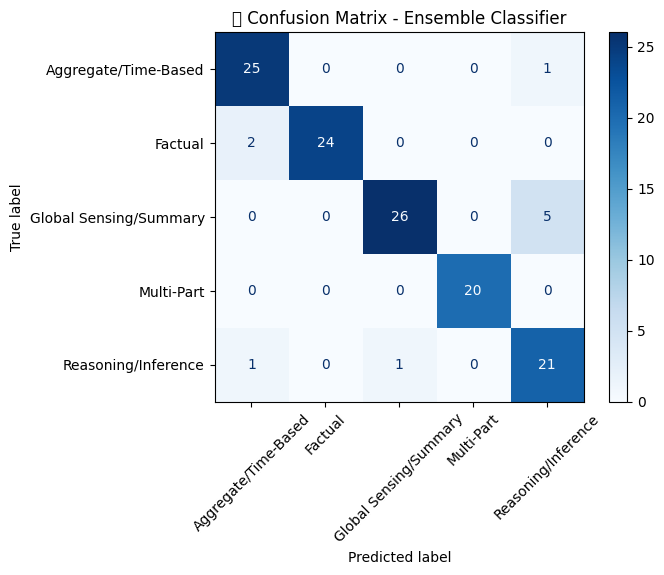

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=le.classes_, cmap="Blues")
plt.title("🧠 Confusion Matrix - Ensemble Classifier")
plt.xticks(rotation=45)
plt.show()


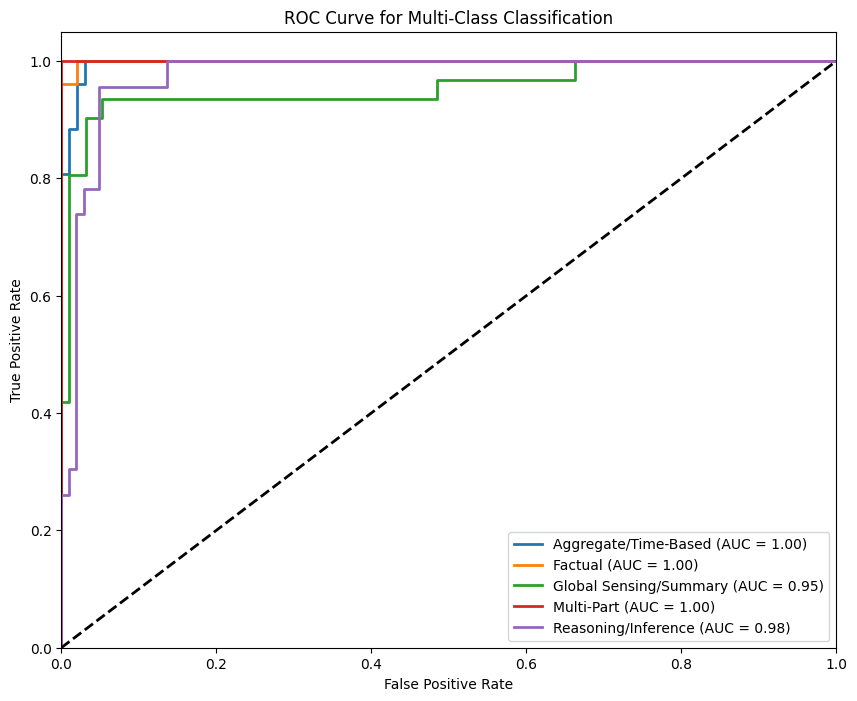

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Assuming you have these already defined:
# - queries (text data)
# - y_encoded (encoded labels)
# - embedder (SentenceTransformer or another embedding model)
# - model (trained model)
# - extract_auxiliary_features (feature extraction function)
# - le (LabelEncoder)

# Step 1: Train-Test Split
# texts_train, texts_test, y_train, y_test = train_test_split(queries, y_encoded, test_size=0.2, random_state=42)

# Step 2: Train Your Model (assuming you have a classifier already trained, if not, train it here)
# model.fit(texts_train, y_train)  # For model training, assuming text data is pre-processed

# Step 3: Evaluate the Model with Logs
def evaluate_model_with_logs(texts_test, y_test, model, embedder, aux_feature_fn, label_encoder):
    y_true = []
    y_pred = []
    y_pred_prob = []  # Store predicted probabilities
    logs = []

    class_names = label_encoder.classes_

    # Make predictions on the test set
    for query, true_label in zip(texts_test, y_test):
        # === Embed + Aux Features
        embedding = embedder.encode([query])
        aux_features = np.array([aux_feature_fn(query)])
        X_input = np.hstack([embedding, aux_features])

        # === Get probabilities
        probs = model.predict_proba(X_input)[0]  # Store predicted probabilities for ROC curve
        predicted_class = np.argmax(probs)  # Get the class with the highest probability
        predicted_classes = label_encoder.inverse_transform([predicted_class])

        # === Accuracy check
        is_correct = true_label in predicted_classes

        y_true.append(true_label)
        y_pred.append(predicted_classes[0])
        y_pred_prob.append(probs)  # Store the predicted probabilities

        logs.append({
            "Query": query,
            "True Label": true_label,
            "Predicted Classes": ", ".join(predicted_classes),
            "Top Prediction": predicted_classes[0],
            "Is Correct": is_correct,
            **{f"P({class_names[i]})": round(probs[i], 4) for i in range(len(class_names))}
        })

    # === Accuracy Calculation
    y_pred_classes = [class_names[np.argmax(probs)] for probs in y_pred_prob]

    # Step 2: Calculate accuracy by comparing predicted classes with actual labels
    correct_predictions = sum([true == pred for true, pred in zip(y_true, y_pred_classes)])

    # Step 3: Calculate overall accuracy
    accuracy = correct_predictions / len(y_true)

    # Step 4: Print the accuracy result


    return y_true, np.array(y_pred_prob), class_names

# Assuming you have model, embedder, aux_feature_fn, and le (label_encoder) already defined
# Run evaluation on the test set
y_true, y_pred_prob, class_names = evaluate_model_with_logs(
    texts_test, y_test, ensemble, embedder, extract_auxiliary_features, le
)

# Step 4: ROC Curve Plotting
def plot_roc_curve(y_true, y_pred_prob, class_names):
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)  # Binarize labels for multi-class

    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve
plot_roc_curve(y_true, y_pred_prob, class_names)


In [30]:
import joblib

# Assuming the label encoder is stored in a variable called 'label_encoder'
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [31]:
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

def explain_prediction(
    text_query,
    model,
    embedder,
    aux_feature_fn,
    label_encoder,
    uncertainty_threshold=1.0,
    prob_diff_threshold=.2,
    show_plot=True
):
    # === 1. Build Full Feature Vector ===
    embedding = embedder.encode([text_query])
    aux_features = np.array([aux_feature_fn(text_query)])
    X_input = np.hstack([embedding, aux_features])

    # === 2. Predict Probabilities ===
    probs = model.predict_proba(X_input)[0]  # returns [n_classes] shape

    # === 3. Decode Class Names ===
    class_names = label_encoder.classes_

    # === 4. Sort and Filter Top Predictions ===
    sorted_indices = np.argsort(probs)[::-1]
    top_prob = probs[sorted_indices[0]]

    predicted_classes = []
    for idx in sorted_indices:
        if top_prob - probs[idx] <= prob_diff_threshold:
            predicted_classes.append((class_names[idx], probs[idx]))
        else:
            break

    # === 5. Entropy (Uncertainty) ===
    entropy_val = entropy(probs)

    # === 6. Print Results ===
    print(f"\n📥 Input Query: {text_query}")
    print("✅ Predicted Class(es):")
    for cls, prob in predicted_classes:
        print(f"  - {cls}: {prob:.4f}")

    print("\n📊 All Class Probabilities:")
    for idx, prob in enumerate(probs):
        print(f"  {class_names[idx]}: {prob:.4f}")

    print(f"\n🔍 Entropy (Uncertainty Score): {entropy_val:.4f}")
    if entropy_val > uncertainty_threshold:
        print("⚠️  Warning: Prediction uncertain. Please double-check.")

    # === 7. Pie Chart ===
    if show_plot:
        plt.figure(figsize=(5, 5))
        plt.pie(probs, labels=class_names, autopct='%1.1f%%', startangle=140)
        plt.title("Class Probability Distribution")
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    # === 8. Return as Dictionary ===
    return {
        "multi_predicted_classes": [cls for cls, _ in predicted_classes],
        "probabilities": dict(zip(class_names, probs)),
        "entropy": entropy_val
    }


In [33]:
model = joblib.load("HPE_multiclass_query_classifier.pkl")

le = joblib.load("label_encoder.pkl")


----------------------------

📥 Input Query: how could HPE’s focus on sustainability have influenced its 2025 profitability?
✅ Predicted Class(es):
  - Reasoning/Inference: 0.8078

📊 All Class Probabilities:
  Aggregate/Time-Based: 0.0316
  Factual: 0.0180
  Global Sensing/Summary: 0.1357
  Multi-Part: 0.0069
  Reasoning/Inference: 0.8078

🔍 Entropy (Uncertainty Score): 0.6592


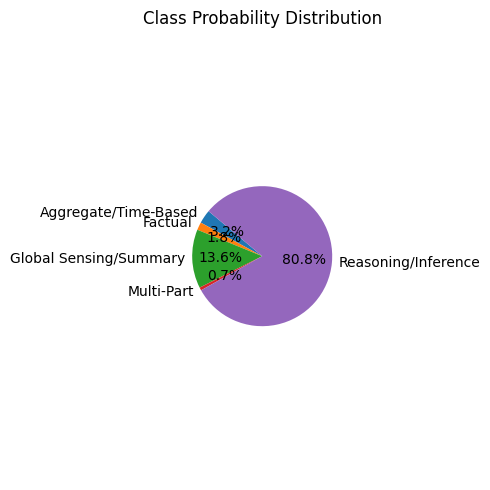

In [34]:
test_queries = [
    "how could HPE’s focus on sustainability have influenced its 2025 profitability?"
]

for q in test_queries:
    print("\n----------------------------")
    explain_prediction(
        text_query=q,
        model=model,
        embedder=embedder,
        aux_feature_fn=extract_auxiliary_features,
        label_encoder=le,
        uncertainty_threshold=1.0,
        prob_diff_threshold=0.2
    )